In [43]:
import time
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler # for scaling
from sklearn.pipeline import make_pipeline # for create classifier with preprocessing
from sklearn.model_selection import cross_val_score, train_test_split # for cross validation, and splitting dataset
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix, roc_curve, accuracy_score 
import pickle
import os
import shutil
from sklearn.model_selection import RandomizedSearchCV
import random
import copy

In [131]:
ht_cut=1750
ptlgMET_cut=150
MET_cut=20
photonPt_cut=60

ht_cut=0
ptlgMET_cut=0
MET_cut=0
photonPt_cut=0

#pre-BDT plots
region="Loose"
bkgProcess=["Wy","Zy","ttg","Zjets","Wjets"]
bkgColor=["r","g","b","m","c"]
bkgLabel=[r"W$\gamma$",r"Z$\gamma$",r"$t\overline{t}\gamma$","Zjets","Wjets"]
productionDir="/home/zhelunli/Desktop/chargedHiggs/ML/"
SaveDirAll=productionDir+"sigBkgPlots"+region+"/"
if os.path.exists(SaveDirAll):
    shutil.rmtree(SaveDirAll)
os.makedirs(SaveDirAll)
Dir=productionDir+"df/"
#storing according to different channel:
bkgDF_e=[]
bkgDF_mu=[]
for process in bkgProcess:
    print("loading",process,"Events")
    df=pd.read_pickle(Dir+process+"_unstack"+region+".df")
    bkgDF_e.append(df[(df["isEchannel"]==1) & (df["Ht"]>ht_cut)& (df[("photonPt",0)]>photonPt_cut)& (df["ptlgMET"]>ptlgMET_cut)& (df["MET"]>MET_cut)])
    bkgDF_mu.append(df[(df["isEchannel"]==0) & (df["Ht"]>ht_cut)& (df[("photonPt",0)]>photonPt_cut)& (df["ptlgMET"]>ptlgMET_cut)& (df["MET"]>MET_cut)])
    
signalMass='150'
SaveDir=SaveDirAll+"sigBkgPlots_m"+str(signalMass)

if os.path.exists(SaveDir):
    shutil.rmtree(SaveDir)
os.makedirs(SaveDir)

signalProcess=["H5pH50_m"+str(signalMass),"H5pH5p_m"+str(signalMass)]
sigLabel=["H5pH50_m"+str(signalMass),"H5pH5p_m"+str(signalMass)]
signalColor=["olive","black"]

sigFactor=[1,1]#scaling higher if no cut is done
if(region=="Loose"):
    sigFactor=[1000,100]

#if (sigFactor!=1):
#    for i in range(len(sigLabel)):
#        sigLabel[i]=sigLabel[i] +"(x "+str(sigFactor)+")"

signalDF_e=[]
signalDF_mu=[]
  
for process in signalProcess:
    print("loading",process,"Events")
    df=pd.read_pickle(Dir+process+"_unstack"+region+".df")
    signalDF_e.append(df[(df["isEchannel"]==1) & (df["Ht"]>ht_cut)& (df[("photonPt",0)]>photonPt_cut)& (df["ptlgMET"]>ptlgMET_cut)& (df["MET"]>MET_cut)])
    signalDF_mu.append(df[(df["isEchannel"]==0) & (df["Ht"]>ht_cut)& (df[("photonPt",0)]>photonPt_cut)& (df["ptlgMET"]>ptlgMET_cut)& (df["MET"]>MET_cut)])

loading Wy Events


FileNotFoundError: [Errno 2] No such file or directory: '/home/zhelunli/Desktop/chargedHiggs/ML/df/Wy_unstackLoose.df'

In [132]:
def plotting(bkg_e,bkg_mu,sig_e,sig_mu,variable,binsize,low,high,name,xlabel,ylabel,bkgLabel,sigLabel,bkgColor,signalColor,sigFactor,SaveDir):
    bins=np.arange(low,high,binsize)
    fig, axs = plt.subplots(2,1)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    
    inputE=[]
    weightE=[]
    inputMu=[]
    weightMu=[]
    histtype='step'
    #histtype='barstacked'
    for i in range (len(bkgLabel)):
        inputE.append(bkg_e[i][variable])
        weightE.append(bkg_e[i]["weight"])
        inputMu.append(bkg_mu[i][variable])
        weightMu.append(bkg_mu[i]["weight"])
    axs[0].hist(inputE,weights=weightE,bins=bins,histtype=histtype,label=bkgLabel,color=bkgColor,alpha = 0.5)
    axs[1].hist(inputMu,weights=weightMu,bins=bins,histtype=histtype,label=bkgLabel,color=bkgColor,alpha = 0.5)
    sigLabel1=copy.copy(sigLabel)
    sigLabel2=copy.copy(sigLabel)
    if (sigFactor[0]!=1):
        for i in range(len(sigLabel)):
            sigLabel1[i]=sigLabel1[i] +"(x "+str(sigFactor[0])+")"
            sigLabel2[i]=sigLabel2[i] +"(x "+str(sigFactor[1])+")"
                
    for i in range(len(sigLabel)):
        axs[0].hist(sig_e[i][variable],weights=sig_e[i]["weight"]*sigFactor[0],bins=bins,histtype='step',label=sigLabel1,color=signalColor[i],lw=4)
        axs[1].hist(sig_mu[i][variable],weights=sig_mu[i]["weight"]*sigFactor[1],bins=bins,histtype='step',label=sigLabel2,color=signalColor[i],lw=4)
    
    axs[0].set_xlabel(xlabel+" (eChannel)",fontsize=20)
    axs[0].set_ylabel(ylabel,fontsize=20)
    axs[0].tick_params(axis = 'both', which = 'major', labelsize = 15)
    axs[0].legend(loc='best',prop={'size': 15})
    #axs[0].grid()
    axs[1].set_xlabel(xlabel+" (muChannel)",fontsize=20)
    axs[1].set_ylabel(ylabel,fontsize=20)
    axs[1].tick_params(axis = 'both', which = 'major', labelsize = 15)
    axs[1].legend(loc='best',prop={'size': 15})
    #axs[1].grid()
    

    fig.savefig(SaveDir+"/"+name)
    plt.close(fig)

In [133]:
plotting(bkgDF_e,bkgDF_mu,signalDF_e,signalDF_mu,"MET",5,0,150,"MET",r"$E_{T}^{miss}$","Entries per 5GeV bin",bkgLabel,sigLabel,bkgColor,signalColor,sigFactor,SaveDir)

IndexError: list index out of range

In [178]:
plotting(bkgDF_e,bkgDF_mu,signalDF_e,signalDF_mu,"ptlgMET",20,0,500,"ptlgMET",r"$p_{T}^{l+\gamma+E_{T}^{miss}}$","Entries per 20GeV bin",bkgLabel,sigLabel,bkgColor,signalColor,sigFactor,SaveDir)

In [130]:
plotting(bkgDF_e,bkgDF_mu,signalDF_e,signalDF_mu,("photonPt",0),20,0,500,"photonPt",r"$photon p_{T}$","Entries per 20GeV bin",bkgLabel,sigLabel,bkgColor,signalColor,sigFactor,SaveDir)

In [180]:
plotting(bkgDF_e,bkgDF_mu,signalDF_e,signalDF_mu,"Ht",50,0,2000,"Ht",r"$H_{T}$","Entries per 50GeV bin",bkgLabel,sigLabel,bkgColor,signalColor,[10,10],SaveDir)

In [181]:
plotting(bkgDF_e,bkgDF_mu,signalDF_e,signalDF_mu,"Ht",50,0,2000,"Ht",r"$H_{T}$","Entries per 50GeV bin",bkgLabel,sigLabel,bkgColor,signalColor,sigFactor,SaveDir)

In [182]:
plotting(bkgDF_e,bkgDF_mu,signalDF_e,signalDF_mu,("photonDR",0),0.1,0,6,"closPhotonDR",r"$\Delta R$","Entries per 0.1 interval",bkgLabel,sigLabel,bkgColor,signalColor,sigFactor,SaveDir)

In [2]:
modelSaveDir="/home/zhelunli/Desktop/chargedHiggs/ML/Models"
signalSamples="m100"
saveDir=modelSaveDir+"/"+signalSamples

In [8]:
test1=pd.read_pickle(modelSaveDir+"/"+signalSamples+"/test1"+".df")
test2=pd.read_pickle(modelSaveDir+"/"+signalSamples+"/test2"+".df")
test3=pd.read_pickle(modelSaveDir+"/"+signalSamples+"/test3"+".df")
test4=pd.read_pickle(modelSaveDir+"/"+signalSamples+"/test4"+".df")
test5=pd.read_pickle(modelSaveDir+"/"+signalSamples+"/test5"+".df")
test=[test1,test2,test3,test4,test5]

y_test1=pd.read_pickle(modelSaveDir+"/"+signalSamples+"/test1Label"+".df")
y_test2=pd.read_pickle(modelSaveDir+"/"+signalSamples+"/test2Label"+".df")
y_test3=pd.read_pickle(modelSaveDir+"/"+signalSamples+"/test3Label"+".df")
y_test4=pd.read_pickle(modelSaveDir+"/"+signalSamples+"/test4Label"+".df")
y_test5=pd.read_pickle(modelSaveDir+"/"+signalSamples+"/test5Label"+".df")
y_test=[y_test1,y_test2,y_test3,y_test4,y_test5]

w_test1=pd.read_pickle(modelSaveDir+"/"+signalSamples+"/test1Weights"+".df")
w_test2=pd.read_pickle(modelSaveDir+"/"+signalSamples+"/test2Weights"+".df")
w_test3=pd.read_pickle(modelSaveDir+"/"+signalSamples+"/test3Weights"+".df")
w_test4=pd.read_pickle(modelSaveDir+"/"+signalSamples+"/test4Weights"+".df")
w_test5=pd.read_pickle(modelSaveDir+"/"+signalSamples+"/test5Weights"+".df")
w_test=[w_test1,w_test2,w_test3,w_test4,w_test5]

p_test1=pd.read_pickle(modelSaveDir+"/"+signalSamples+"/test1process"+".df")
p_test2=pd.read_pickle(modelSaveDir+"/"+signalSamples+"/test2process"+".df")
p_test3=pd.read_pickle(modelSaveDir+"/"+signalSamples+"/test3process"+".df")
p_test4=pd.read_pickle(modelSaveDir+"/"+signalSamples+"/test4process"+".df")
p_test5=pd.read_pickle(modelSaveDir+"/"+signalSamples+"/test5process"+".df")
p_test=[p_test1,p_test2,p_test3,p_test4,p_test5]

train1=test2.append(test3,ignore_index=True).append(test4,ignore_index=True).append(test5,ignore_index=True)
train2=test1.append(test3,ignore_index=True).append(test4,ignore_index=True).append(test5,ignore_index=True)
train3=test2.append(test1,ignore_index=True).append(test4,ignore_index=True).append(test5,ignore_index=True)
train4=test2.append(test3,ignore_index=True).append(test1,ignore_index=True).append(test5,ignore_index=True)
train5=test2.append(test3,ignore_index=True).append(test4,ignore_index=True).append(test1,ignore_index=True)
train=[train1,train2,train3,train4,train5]

y_train1=y_test2.append(y_test3,ignore_index=True).append(y_test4,ignore_index=True).append(y_test5,ignore_index=True)
y_train2=y_test1.append(y_test3,ignore_index=True).append(y_test4,ignore_index=True).append(y_test5,ignore_index=True)
y_train3=y_test2.append(y_test1,ignore_index=True).append(y_test4,ignore_index=True).append(y_test5,ignore_index=True)
y_train4=y_test2.append(y_test3,ignore_index=True).append(y_test1,ignore_index=True).append(y_test5,ignore_index=True)
y_train5=y_test2.append(y_test3,ignore_index=True).append(y_test4,ignore_index=True).append(y_test1,ignore_index=True)
y_train=[y_train1,y_train2,y_train3,y_train4,y_train5]

w_train1=w_test2.append(w_test3,ignore_index=True).append(w_test4,ignore_index=True).append(w_test5,ignore_index=True)
w_train2=w_test1.append(w_test3,ignore_index=True).append(w_test4,ignore_index=True).append(w_test5,ignore_index=True)
w_train3=w_test2.append(w_test1,ignore_index=True).append(w_test4,ignore_index=True).append(w_test5,ignore_index=True)
w_train4=w_test2.append(w_test3,ignore_index=True).append(w_test1,ignore_index=True).append(w_test5,ignore_index=True)
w_train5=w_test2.append(w_test3,ignore_index=True).append(w_test4,ignore_index=True).append(w_test1,ignore_index=True)
w_train=[w_train1,w_train2,w_train3,w_train4,w_train5]


In [12]:
def plot_importance(importance):
    importance_df=pd.DataFrame(np.array([np.array(test1.columns),importance]).transpose(),columns=['feature','importance'])
    importance_df=importance_df.sort_values(by='importance', ascending=True)
    fig=plt.figure(figsize=(10,30))
    plt.title('Feature Importances')
    plt.barh(range(len(test1.columns)), importance_df['importance'], color='b', align='center')
    plt.yticks(range(len(test1.columns)),importance_df['feature'])
    plt.xlabel('Importance')
    plt.show()
    fig.savefig(saveDir+"/importance_"+signalSamples+".pdf")

In [13]:
Models=[]
for i in range(5):
    loaded_model = pickle.load(open(saveDir+"/Model"+str(i+1), 'rb'))
    Models.append(loaded_model)

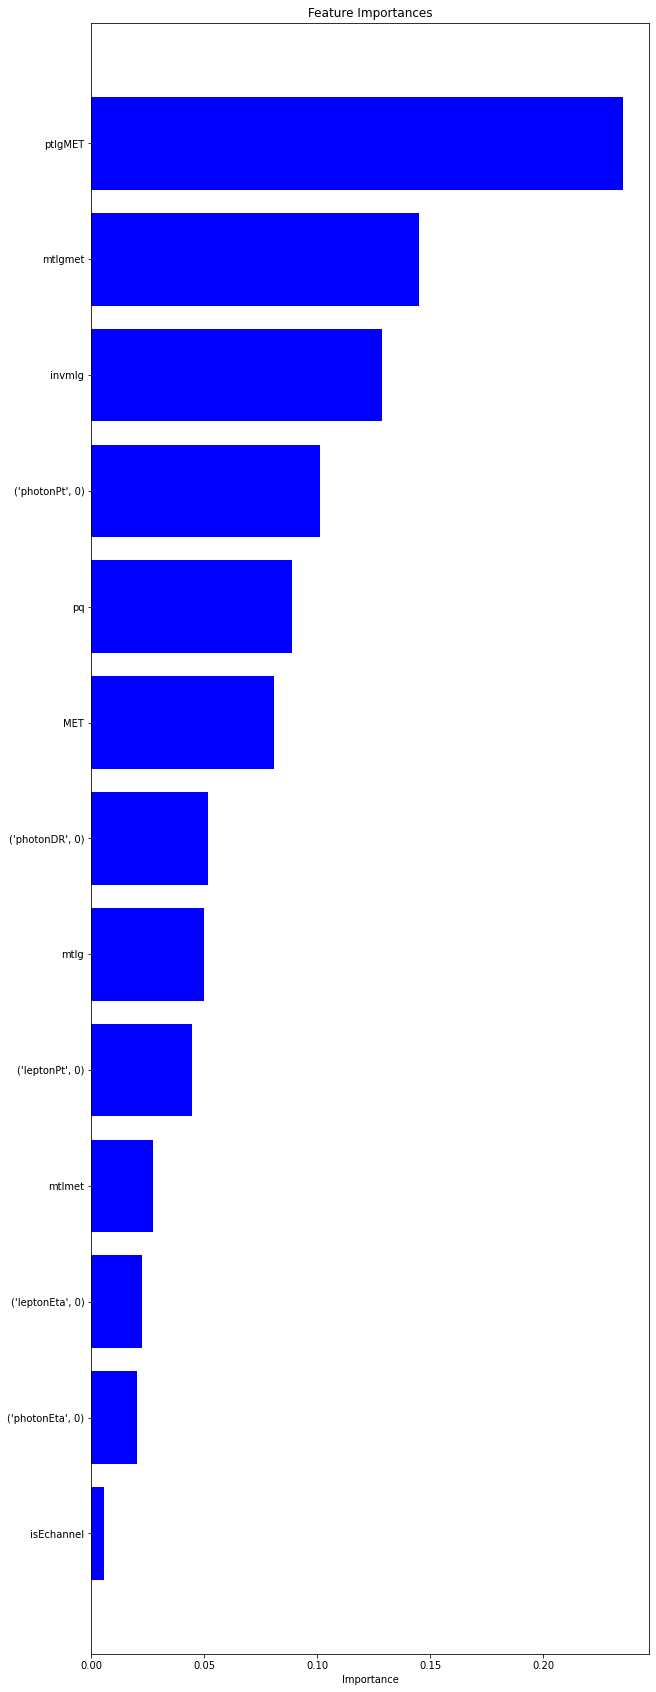

In [14]:
plot_importance(Models[0].feature_importances_)

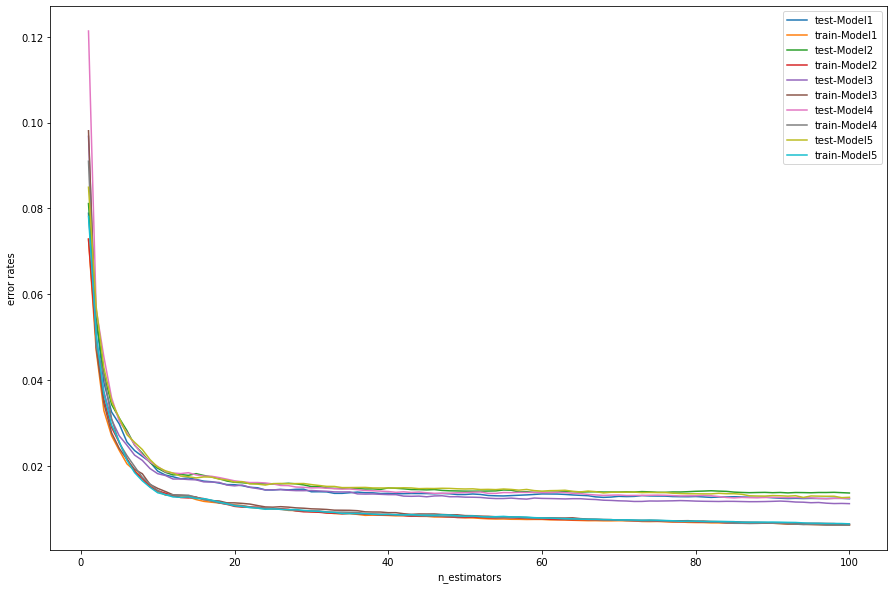

time taken =  77.41337132453918


In [15]:
time0=time.time()
n_trees = Models[0].get_params()['n_estimators']
fig=plt.figure(1,figsize=(15,10))
test_error_all=[]
train_error_all=[]
for index,clf_best in enumerate(Models):#plotting:
    test_errors = []
    train_errors=[]
    for i, y_pred in enumerate(clf_best.staged_predict(test[index])):
        test_errors.append( 1. - accuracy_score(y_pred, y_test[index],sample_weight=abs(w_test[index])))
    for i, y_pred in enumerate(clf_best.staged_predict(train[index])):
        train_errors.append( 1. - accuracy_score(y_pred, y_train[index],sample_weight=abs(w_train[index])))
    test_error_all.append(test_errors)
    train_error_all.append(train_errors)
    plt.plot(np.arange(1,n_trees+1,1),test_errors,label="test-Model"+str(index+1))
    plt.plot(np.arange(1,n_trees+1,1),train_errors,label="train-Model"+str(index+1))
plt.xlabel("n_estimators")
plt.ylabel("error rates")
plt.legend()
plt.show()
fig.savefig(saveDir+"/errorRates_"+signalSamples)
axes = plt.gca()
axes.set_ylim([0,0.02])
plt.close(fig)
print("time taken = ",time.time()-time0)

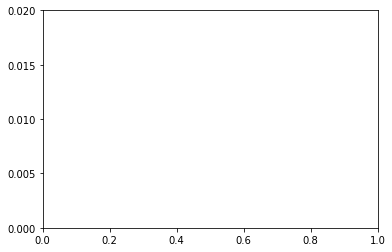

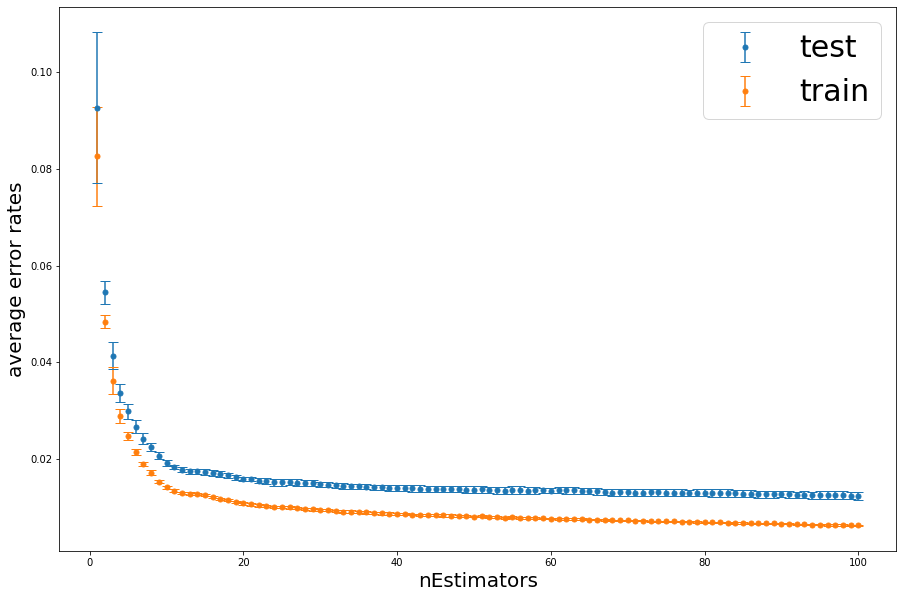

In [16]:
test_error_all=np.array(test_error_all)
train_error_all=np.array(train_error_all)
fig3=plt.figure(5,figsize=(15,10))
plt.errorbar(np.arange(1,n_trees+1,1),test_error_all.T.mean(axis=1),test_error_all.T.std(axis=1),fmt='.',capsize=5,markersize=10,label='test')
plt.errorbar(np.arange(1,n_trees+1,1),train_error_all.T.mean(axis=1),train_error_all.T.std(axis=1),fmt='.',capsize=5,markersize=10,label='train')
plt.legend( prop={'size': 30})
plt.xlabel("nEstimators",size=20)
plt.ylabel("average error rates",size=20)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
axes = plt.gca()
#axes.set_ylim([0,0.02])
fig3.savefig(saveDir+"/errorRatesAvg_"+signalSamples)
plt.show()
plt.close(fig3)

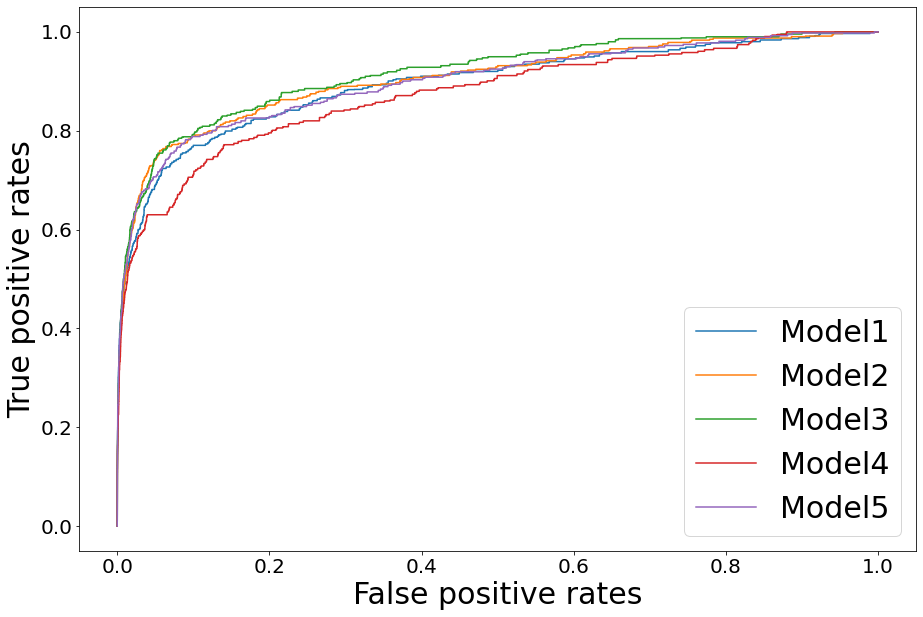

In [17]:
fig=plt.figure(2,figsize=(15,10))
for index,clf_best in enumerate(Models):
    fpr,tpr,thresholds=roc_curve(y_test[index],clf_best.predict_proba(test[index]).T[1],sample_weight=abs(w_test[index]))
    plt.plot(fpr, tpr,label='Model'+str(index+1))
plt.xlabel("False positive rates",size=30)
plt.ylabel("True positive rates",size=30)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.legend( prop={'size': 30})
plt.show()
fig.savefig(saveDir+"/ROC_"+signalSamples+".pdf")
plt.close(fig)

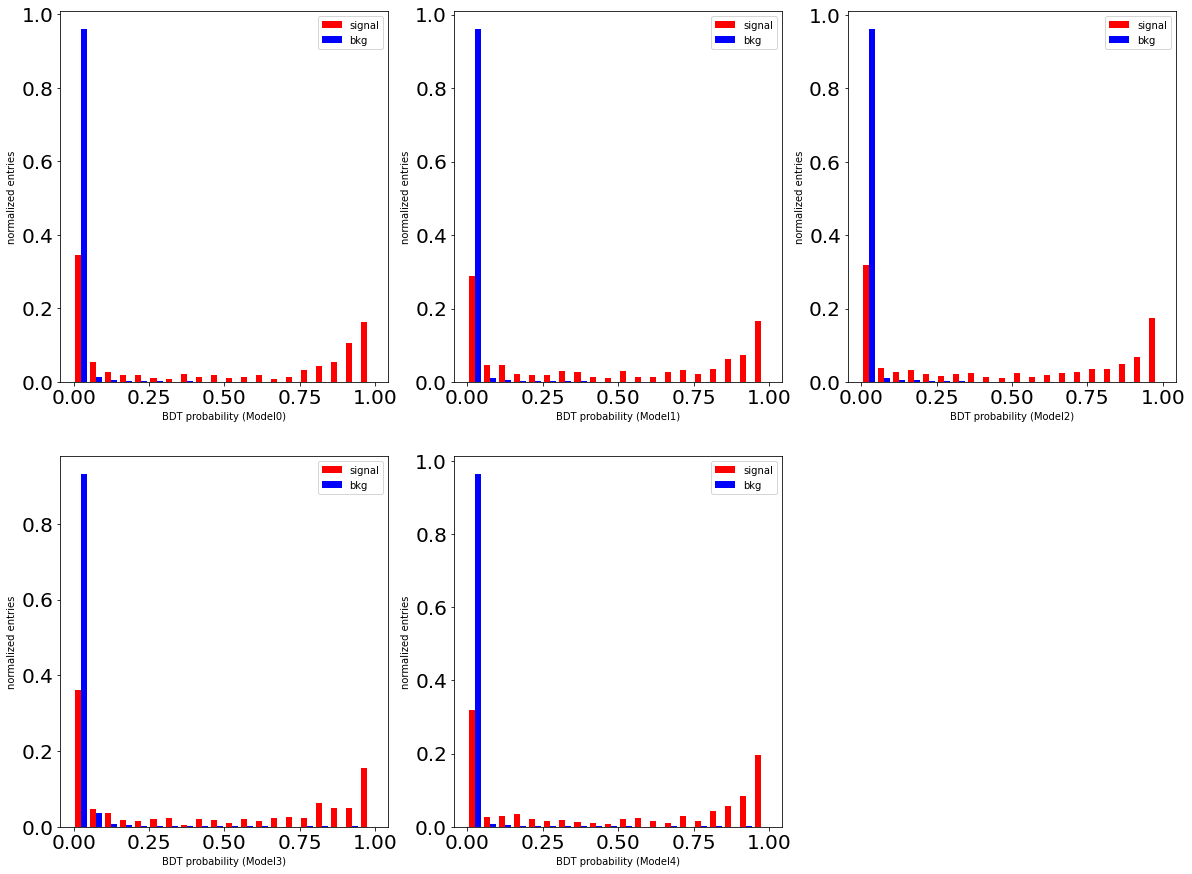

0.05


In [18]:
figProb,ax=plt.subplots(2,3,figsize=(20,15))
ax=ax.reshape(6,1)
step=0.05
bins=np.arange(0,1+step,step)
histSig=[]
histBkg=[]
#first prob out of predict is class 0 which is bkg. This is easily checked
for index,clf_best in enumerate(Models):
    pred=[clf_best.predict_proba(test[index][y_test[index]==1]).T[1],clf_best.predict_proba(test[index][y_test[index]==0]).T[1]]
    weights=[abs(w_test[index][y_test[index]==1])/abs(w_test[index][y_test[index]==1]).sum(),abs(w_test[index][y_test[index]==0])/abs(w_test[index][y_test[index]==0]).sum()]
    label=["signal","bkg"]
    color=['r','b']
    histSig.append(np.histogram(pred[0],weights=weights[0],bins=bins)[0])
    histBkg.append(np.histogram(pred[1],weights=weights[1],bins=bins)[0])
    probBins=np.histogram(pred[1],weights=weights[1],bins=bins)[1]
    ax[index][0].hist(pred,weights=weights,bins=bins,color=color,label=label)
    ax[index][0].set_xlabel("BDT probability (Model"+str(index)+")")
    ax[index][0].set_ylabel("normalized entries")
    ax[index][0].legend()
    plt.close(index+2)
figProb.delaxes(ax[5][0])
plt.show()
figProb.savefig(saveDir+"/Prob_"+signalSamples+".pdf")
plt.close(figProb)

print(probBins[1]-probBins[0])
width=0.5*(probBins[1]-probBins[0])
probBins=probBins[0:-1]+width
stdSig=np.std(histSig,axis=0)
histSig=np.mean(histSig,axis=0)
stdBkg=np.std(histBkg,axis=0)
histBkg=np.mean(histBkg,axis=0)


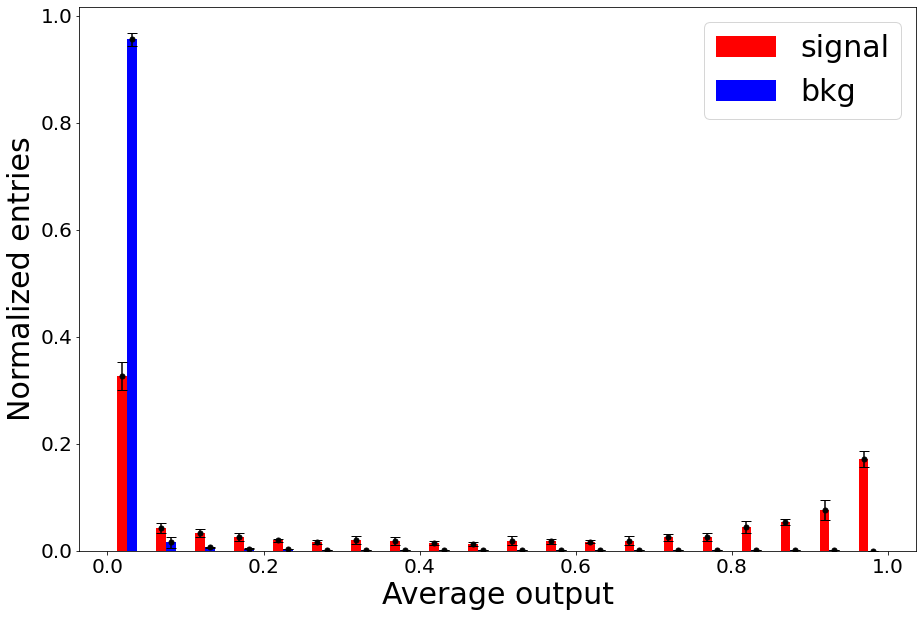

In [19]:
fig=plt.figure(6,figsize=(15,10))
plt.bar(probBins-0.25*width,histSig,width=0.5*width,color='r',label='signal')
plt.errorbar(probBins-0.25*width,histSig,yerr=stdSig,color='k',fmt='.',capsize=5,markersize=10)
plt.bar(probBins+0.25*width,histBkg,width=0.5*width,color='b',label='bkg')
plt.errorbar(probBins+0.25*width,histBkg,yerr=stdBkg,fmt='.',color='k',capsize=5,markersize=10)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.xlabel("Average output",size=30)
plt.ylabel("Normalized entries",size=30)
plt.legend(prop={'size': 30})
plt.show()
fig.savefig(saveDir+"/avgProb_"+signalSamples+".pdf")
plt.close(fig)

In [20]:
time0=time.time()
bkgAllWeight=[]
sigAllWeight=[]
for i in range(11):
    cut_off=i*0.1
    sig=pd.DataFrame( columns=test[0].columns)
    bkg=pd.DataFrame( columns=test[0].columns)
    w_bkg=np.array([])
    w_sig=np.array([])
    #first prob out of predict is class 0 which is bkg. This is easily checked
    for index,clf_best in enumerate(Models):
        tmp_bkg=test[index][y_test[index]==0]

        tmp_sig=test[index][y_test[index]==1]
        tmp_wbkg=w_test[index][y_test[index]==0]
        tmp_wsig=w_test[index][y_test[index]==1]

        bkg_pred=clf_best.predict_proba(tmp_bkg).T[1]
        bkg=bkg.append(tmp_bkg[bkg_pred>cut_off],ignore_index=True)
        w_bkg=np.append(w_bkg,tmp_wbkg[bkg_pred>cut_off])

        sig_pred=clf_best.predict_proba(tmp_sig).T[1]
        sig=sig.append(tmp_sig[sig_pred>cut_off],ignore_index=True)
        w_sig=np.append(w_sig,tmp_wsig[sig_pred>cut_off])
    bkgAllWeight.append(w_bkg.sum())
    sigAllWeight.append(w_sig.sum())
    print('cutoff = ',cut_off,' finished')
bkgAllWeight=np.array(bkgAllWeight)
sigAllWeight=np.array(sigAllWeight)
print("time taken = ",time.time()-time0)

cutoff =  0.0  finished
cutoff =  0.1  finished
cutoff =  0.2  finished
cutoff =  0.30000000000000004  finished
cutoff =  0.4  finished
cutoff =  0.5  finished
cutoff =  0.6000000000000001  finished
cutoff =  0.7000000000000001  finished
cutoff =  0.8  finished
cutoff =  0.9  finished
cutoff =  1.0  finished
time taken =  124.63887763023376


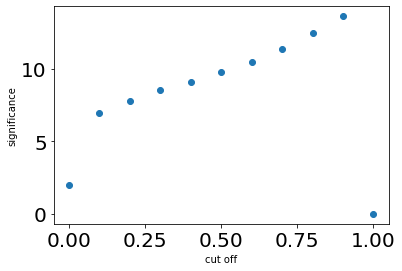

In [21]:
sf_List=sigAllWeight/np.sqrt(bkgAllWeight+0.001)

fig=plt.figure(5)
plt.scatter(np.arange(0,1.1,0.1),sf_List)
plt.xlabel('cut off')
plt.ylabel('significance')
plt.show()
fig.savefig(saveDir+"/significance_"+signalSamples+".pdf")
plt.close(fig)


In [36]:
Models[0]

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         max_depth=10,
                                                         max_features='sqrt',
                                                         min_samples_leaf=15,
                                                         min_samples_split=15,
                                                         min_weight_fraction_leaf=1e-05),
                   learning_rate=0.007, n_estimators=100)

In [36]:
cut_off=0.3
sig=pd.DataFrame( columns=test[0].columns)
bkg=pd.DataFrame( columns=test[0].columns)
w_bkg=np.array([])
w_sig=np.array([])
p_bkg=[]
#first prob out of predict is class 0 which is bkg. This is easily checked
for index,clf_best in enumerate(Models):
    tmp_bkg=test[index][y_test[index]==0]
    tmp_sig=test[index][y_test[index]==1]
    tmp_wbkg=w_test[index][y_test[index]==0]
    tmp_wsig=w_test[index][y_test[index]==1]
    tmp_pbkg=p_test[index][y_test[index]==0]
    
    bkg_pred=clf_best.predict_proba(tmp_bkg).T[1]
    bkg=bkg.append(tmp_bkg[bkg_pred>cut_off],ignore_index=True)
    w_bkg=np.append(w_bkg,tmp_wbkg[bkg_pred>cut_off])
    p_bkg.append(tmp_pbkg[bkg_pred>cut_off])
    
    sig_pred=clf_best.predict_proba(tmp_sig).T[1]
    sig=sig.append(tmp_sig[sig_pred>cut_off],ignore_index=True)
    w_sig=np.append(w_sig,tmp_wsig[sig_pred>cut_off])


In [37]:
bkgSamples=["Wy","Zy","Wjets","Zjets","ttg"]

In [38]:
P_bkg=p_bkg[0]
for i in range(1,len(p_bkg)):
    P_bkg=P_bkg.append(p_bkg[i],ignore_index=True)

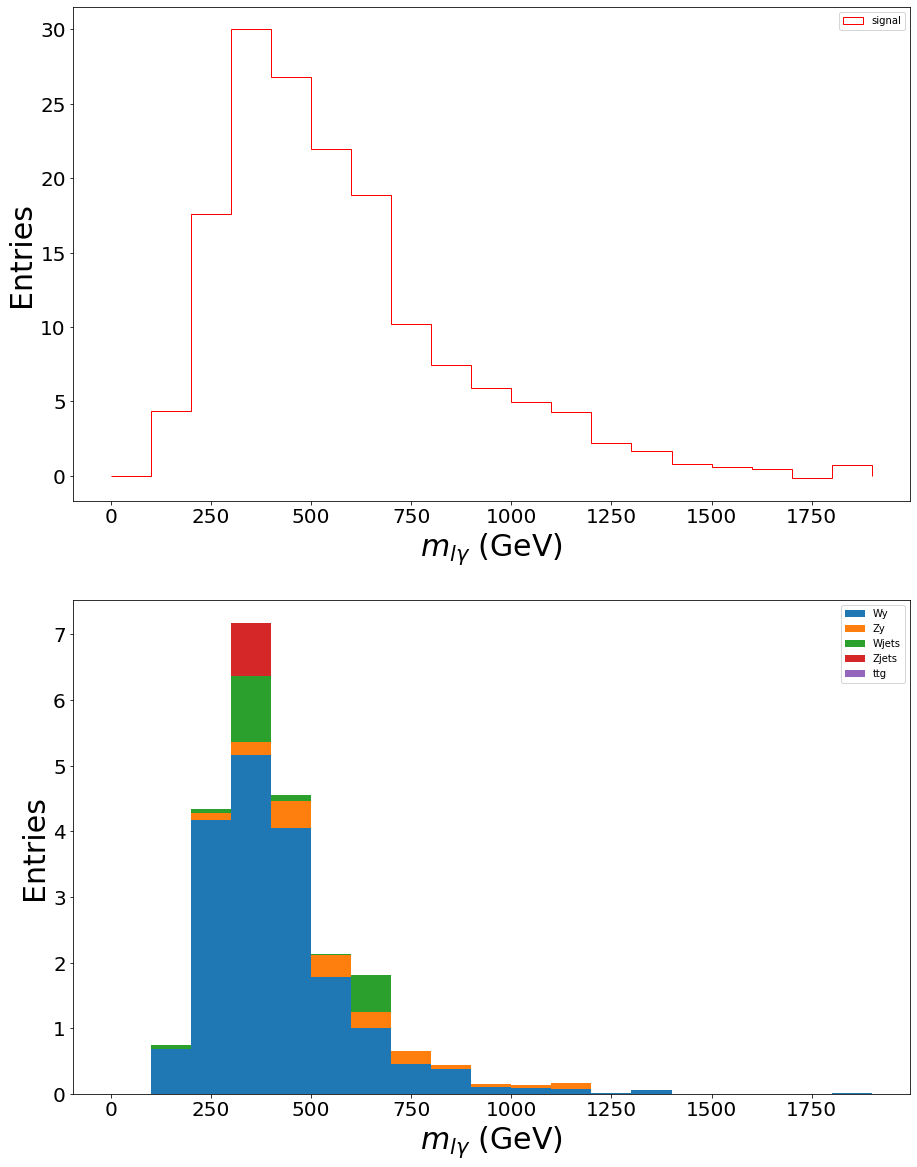

In [39]:
fig,ax=plt.subplots(2,1,figsize=(15,20))
bins=np.arange(0,2000,100)
ax[0].hist(sig['invmlg'],bins=bins,label='signal',weights=w_sig,color='r',histtype='step')
ax[0].set_xlabel(r"$m_{l\gamma}$ (GeV)",size=30)
ax[0].set_ylabel("Entries",size=30)
ax[0].legend()
#plt.show()


w_list=[]
b_list=[]
for process in bkgSamples:
    bkg[P_bkg==process]
    tmpBkg=bkg[P_bkg==process]
    tmpWbkg=w_bkg[P_bkg==process]
    b_list.append(tmpBkg['invmlg'])
    w_list.append(tmpWbkg)
    #plt.hist(bkg[P_bkg==process]['invmlg'],bins=bins,label=process,weights=w_bkg[P_bkg==process],stacked=True)
ax[1].hist(b_list,bins=bins,label=bkgSamples,weights=w_list,stacked=True)

ax[1].set_xlabel(r"$m_{l\gamma}$ (GeV)",size=30)
ax[1].set_ylabel("Entries",size=30)
ax[1].legend()

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.show()
fig.savefig(saveDir+"/invmlg_"+signalSamples+".pdf")
plt.close(fig)

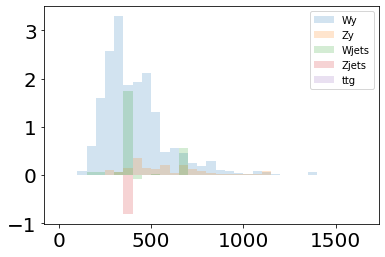

In [42]:
fig=plt.figure(4)
bins=np.arange(0,1700,50)
for process in bkgSamples:
        plt.hist(bkg[P_bkg==process]['invmlg'],bins=bins,label=process,weights=w_bkg[P_bkg==process],alpha=0.2)

plt.legend()
plt.show()
fig.savefig(saveDir+"/invmlg_Nostack_"+signalSamples)
plt.close(fig)